In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

## Data Import

In [207]:
df1=pd.read_csv('shipping_tag1.csv')
df2=pd.read_csv('shipping_tag2.csv')

In [208]:
df1.head()


,tag,message
0,AttemptFail,Próba doręczenia
1,AttemptFail,Delivery attempt
2,AttemptFail,"Vi har været forbi med din forsendelse, men vi traf desværre ingen hjemme. Du kan normalt hente din forsendelse næste dag. Du får flere informationer om hvor, så snart den er klar til afhentning."
3,AttemptFail,Delivery attempt
4,AttemptFail,Delivery attempted; recipient not home


In [209]:
df2.head()

,tag,message,original_message
0,AttemptFail,"Vi har været forbi med din forsendelse, men vi traf desværre ingen hjemme. Du kan normalt hente din forsendelse næste dag. Du får flere informationer om hvor, så snart den er klar til afhentning.",NaN
1,AttemptFail,ATTEMPTED DELIVERY,NaN
2,AttemptFail,Delivery attempt,NaN
3,AttemptFail,Delivery was not possible. The recipient will get a notification with information on where the shipment item will be available for collection.,NaN
4,AttemptFail,"Vi har været forbi med din forsendelse, men vi traf desværre ingen hjemme. Du kan normalt hente din forsendelse næste dag. Du får flere informationer om hvor, så snart den er klar til afhentning.",NaN


In [210]:
del df2['original_message']

In [211]:
df=pd.concat([df1,df2])

## Data Cleaning

In [212]:
#check duplicates
sum(df.duplicated())

953784

In [213]:
df.drop_duplicates(inplace=True)

In [214]:
#check messages with multiple tags
message_count=df['message'].value_counts()
dup_message=message_count[message_count>1].index
len(dup_message)

137

In [215]:
#drop those with multiple tags
df=df[~df['message'].isin(dup_message)]

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'AttemptFail'),
  Text(1, 0, 'AvailableForPickup'),
  Text(2, 0, 'Delivered'),
  Text(3, 0, 'Exception'),
  Text(4, 0, 'InTransit'),
  Text(5, 0, 'InfoReceived'),
  Text(6, 0, 'OutForDelivery')])

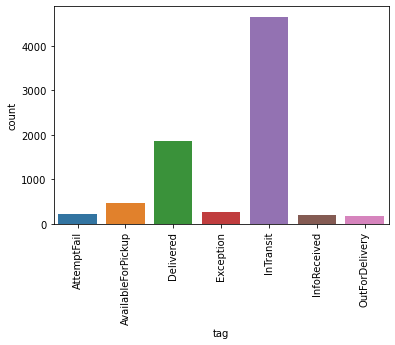

In [216]:
sns.countplot(data=df,x='tag')
plt.xticks(rotation=90)

In [217]:
df['tag']=df['tag'].astype('category')
df['tag_code']=df['tag'].cat.codes
code_map=dict(zip(df['tag'].cat.codes,df['tag']))

In [218]:
df.sample(100)

,tag,message,tag_code
117451,InTransit,Item Despatched to Dinnington DO,4
479209,InTransit,Item Despatched to Bathgate DO,4
100159,InTransit,"Your delivery was received by An Post in THURLES D.S.U., CO TIPPERARY",4
856,AttemptFail,"The item has been returned to the sender., The item has not been picked up or agreeing on the delivery has failed, so it has been returned to the sender. Please contact the sender if necessary.",0
128677,InTransit,Re-delivery requested for 30 Sep 2021 (with ATL),4
767476,AttemptFail,Parcel not delivered - wrong address,0
70368,Delivered,The parcel has been delivered at the neighbour´s (see signature) Signed by: Burem|BUREN22,2
190640,InTransit,Cube/Weigh - In Transit Length 17.5cm Width 13cm Height 6.5 cm Weight 1kg,4
47013,InTransit,Item Despatched to Redcar DO,4
173197,InTransit,DISPATCH CLOS IRAKLEIO SORTING CENTER,4


## NLP

In [219]:
import spacy
import spacy_fastlang
from googletrans import Translator

In [220]:
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("language_detector")
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [221]:
real_stopwords=stopwords-{"not","n't","out",'re'}

In [222]:
## use ner tag to replace location, name
def ner_replacement(article):
    doc=nlp(article)
    ner=[(token.text,token.label_) for token in doc.ents]
    for text, entity in ner:
        article=article.replace(text,entity)
    return article


In [223]:
## eg
ner_replacement('The parcel has been delivered. Signed by Mass')


'The parcel has been delivered. Signed by PERSON'

In [224]:
## Construct the tokenizer
def cust_lemmatizer(article):
    doc=nlp(article)
    if doc._.language!='en':
        en_article=Translator().translate(article, dest='en').text
    else:
        en_article=article
    simplified_en_article=ner_replacement(en_article)
    clean_en_article=' '.join(re.findall("[A-Za-z _\-']+",simplified_en_article))
    doc1=nlp(clean_en_article)
    lemmas=[token.lemma_ for token in doc1 if not token.is_space]
    return [lemma for lemma in lemmas if lemma not in real_stopwords]
    
    

In [225]:
cust_lemmatizer("We're not able to deliver your parcel to the address we have. Please get in touch so we can get it back on its way to you. Contact details can be found in the FAQs section below")

['not',
 'able',
 'deliver',
 'parcel',
 'address',
 'touch',
 'way',
 'contact',
 'detail',
 'find',
 'faq',
 'section']

In [226]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(tokenizer=cust_lemmatizer,ngram_range=(1,2),min_df=3)

In [227]:
X=df.message.values
y=df.tag_code.values

In [228]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=3)

In [229]:
X_train_vector=vectorizer.fit_transform(X_train)

c:\Users\paulx\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [230]:
X_test_vector=vectorizer.transform(X_test)

In [231]:
print(X_train_vector.toarray().shape)
print(X_test_vector.toarray().shape)

(6264, 1405)
(1566, 1405)


## Modeling

In [232]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [240]:
model_params = {
    'svm': {
        'model': SVC(),
        'params' : {
            'C': [1, 5,10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale','auto']
        }  
    },
    'xgboost': {
        'model': XGBClassifier(),
        'params' : {
                'max_depth': [4, 6, 8],
                'n_estimators': [ 100, 250,500,750],
                "learning_rate": [0.01,0.1,0.3],
                'colsample_bytree': np.arange(0.5, 1.0, 0.1),
                'colsample_bylevel': np.arange(0.5, 1.0, 0.1)
        }
    },
     'nb' : {
        'model': MultinomialNB(),
        'params': {
            'alpha': np.arange(1,10,1)
        }
    }
}

In [242]:
scores = []

for model_name, mp in model_params.items():
    model =  RandomizedSearchCV(mp['model'], mp['params'], cv=3, n_iter=30)
    model.fit(X_train_vector, y_train)
    scores.append({
        'model': model_name,
        'best_score': round(model.best_score_,2),
        'best_params': model.best_params_
    })
    
pd.DataFrame(scores,columns=['model','best_score','best_params'])

c:\Users\paulx\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\paulx\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=30. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,model,best_score,best_params
0,svm,0.96,"{'kernel': 'rbf', 'gamma': 'scale', 'C': 5}"
1,xgboost,0.96,"{'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8999999999999999}"
2,nb,0.93,{'alpha': 8}


In [245]:
xgb=XGBClassifier(n_estimators=250, max_depth=6, learning_rate=0.3,colsample_bylevel=0.9,colsample_bytree= 0.6)
xgb.fit(X_train_vector, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [261]:
svm=SVC(kernel='rbf',gamma='scale',C=5,probability=True)
svm.fit(X_train_vector, y_train)

SVC(C=5, probability=True)

In [262]:
## SVM and XGboost similar performance, compare on test set
print('SVM:',svm.score(X_test_vector,y_test))
print('XGBoost:',xgb.score(X_test_vector,y_test))

SVM: 0.9623243933588761
XGBoost: 0.9597701149425287


In [263]:
from sklearn.metrics import classification_report
print('SVM: \n', classification_report(y_test,svm.predict(X_test_vector),target_names=code_map.values()))

print('XGBoost: \n', classification_report(y_test,xgb.predict(X_test_vector),target_names=code_map.values()))

SVM: 
                     precision    recall  f1-score   support

       AttemptFail       0.94      0.77      0.85        43
AvailableForPickup       0.99      0.93      0.96        92
         Delivered       0.97      0.98      0.98       372
         Exception       0.86      0.76      0.81        55
         InTransit       0.96      0.99      0.97       932
      InfoReceived       1.00      0.84      0.91        38
    OutForDelivery       1.00      0.82      0.90        34

          accuracy                           0.96      1566
         macro avg       0.96      0.87      0.91      1566
      weighted avg       0.96      0.96      0.96      1566

XGBoost: 
                     precision    recall  f1-score   support

       AttemptFail       0.91      0.74      0.82        43
AvailableForPickup       0.96      0.95      0.95        92
         Delivered       0.98      0.97      0.98       372
         Exception       0.75      0.78      0.77        55
         InTransit

## Model Evaluation

In [264]:
## Choose svm

In [265]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

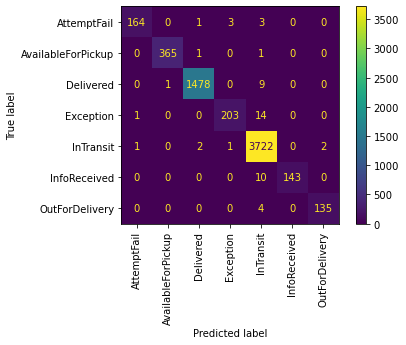

In [266]:
cm2=confusion_matrix(y_train,svm.predict(X_train_vector),labels=np.arange(0,7))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=code_map.values())
disp_train.plot()
plt.xticks(rotation=90)
plt.show()

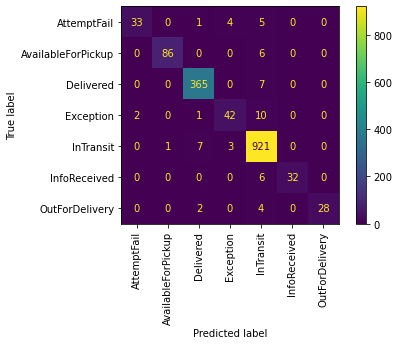

In [267]:
cm1=confusion_matrix(y_test,svm.predict(X_test_vector),labels=np.arange(0,7))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=code_map.values())
disp_test.plot()
plt.xticks(rotation=90)
plt.show()

In [268]:
dfx=pd.DataFrame(X_test)
dfy=pd.DataFrame(y_test)
dfy_=pd.DataFrame(svm.predict(X_test_vector))
df_check=pd.concat([dfx,dfy,dfy_],axis=1)

In [269]:
df_check['true label']=df_check.iloc[:,1].map(code_map)
df_check['predict label']=df_check.iloc[:,2].map(code_map)

In [270]:
pd.set_option('display.max_rows',None)
df_check[df_check['true label']!=df_check['predict label']]

,0,0,0,true label,predict label
17,Pick up,2,4,Delivered,InTransit
20,FAILED_DELIVERY - 送達客戶不在，楊梅營業所保管中。,3,4,Exception,InTransit
50,ZIPCODE VALIDATION,3,4,Exception,InTransit
62,Unsuccessful delivery,0,4,AttemptFail,InTransit
72,DECEASED,3,4,Exception,InTransit
90,Notice Left: No Secure Location Available,4,3,InTransit,Exception
96,The delivery of the shipment item has been delayed with one workday.,3,4,Exception,InTransit
119,Out for Pickup,1,4,AvailableForPickup,InTransit
121,ELECTRONIC SHIPPING INFO RECEIVED,5,4,InfoReceived,InTransit
178,Item presented : addressee absent - message left in addressee's letterbox,0,4,AttemptFail,InTransit


In [286]:
## construct pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline([('vectorizer', vectorizer), ('SVM', svm)])
pipe_xgb = Pipeline([('vectorizer', vectorizer), ('XGBoost', xgb)])

In [272]:
def status_classify(status):
    if type(status)==str:
        status=[status]
    CLASS=pipe.predict(status)
    LABEL=[code_map[target] for target in CLASS]
    PROB=pipe.predict_proba(status)
    PROB.sort(axis=1)
    return list(zip(LABEL,PROB[:,-1]))

In [287]:
def status_classify_xgb(status):
    if type(status)==str:
        status=[status]
    CLASS=pipe_xgb.predict(status)
    LABEL=[code_map[target] for target in CLASS]
    PROB=pipe_xgb.predict_proba(status)
    PROB.sort(axis=1)
    return list(zip(LABEL,PROB[:,-1]))

In [288]:
status_classify("DELIVERY")

[('InTransit', 0.9363313115510349)]